miniconda environment: 
- tensorflow 2.10.0 (GPU setup)
- python 3.10.4

In [1]:
import tensorflow as tf
print(f"Tensorflow version: {tf.__version__}")
import numpy as np
import matplotlib.pyplot as plt
from tensorboard import notebook
import time
from datetime import datetime
import os

# Launch tensorboard in VS-Code
%load_ext tensorboard

# If using GPU, specify XLA_GPU_CUDA path (comment out otherwise)
os.environ["XLA_FLAGS"] = "--xla_gpu_cuda_data_dir=C:/Users/Harry/miniconda3/envs/tf/Library/bin"

tf.keras.backend.set_floatx('float32')
np.set_printoptions(precision=5, edgeitems=10, linewidth=1000, suppress=True)

Tensorflow version: 2.10.0


# Carmona problem

We consider a stochastic differential game with $N$ players, and we denote by $\mathcal{I} := {1, 2, \dots, N}$ the set of players. Let $T$ be a finite time horizon. At each time $t \in [0, T]$, player $i \in \mathcal{I}$ has a state $X_{t}^{i} \in \mathbb{R}$ and takes an action $\alpha_{t}^{i} \in \mathbb{R}$. The dynamics of the controlled state process $X_{i}$ on $[0, T]$ are given by:

$$\mathrm{d} X_t^i=\left[a\left(\bar{X}_t-X_t^i\right)+\alpha_t^i\right] \mathrm{d} t+\sigma\left(\rho \mathrm{d} W_t^0+\sqrt{1-\rho^2} \mathrm{~d} W_t^i\right)$$

where $\boldsymbol{W}:=\left[W^0, W^1, \ldots, W^N\right]$ are ($N+1$) $m$-dimensional independent Brownian motions, with $W^{i}$ the individual noises and $W^{0}$ the common noise.

Given a set of strategies $(\bold{\alpha}_{t})_{t \in [0, T]}$, the cost associated to player $i$ is of the form
$$ J^{i}(\alpha): \alpha \mapsto \mathbb{E}\left[\int_0^T f^{i}\left(t, X_t, \alpha_{t}\right) dt+g^{i}(X_T)\right], $$

Here $f^i:[0, T] \times \mathbb{R}^N \times \mathbb{R}^N \rightarrow \mathbb{R}$ denotes the running cost, and $g^i: \mathbb{R}^N \rightarrow \mathbb{R}$ the terminal cost, where:
$$f^i(t, \boldsymbol{x}, \boldsymbol{\alpha})=\frac{1}{2}\left(\alpha^i\right)^2-q \alpha^i\left(\bar{x}-x^i\right)+\frac{\epsilon}{2}\left(\bar{x}-x^i\right)^2$$
$$g^i(\boldsymbol{x})=\frac{c}{2}\left(\bar{x}-x^i\right)^2$$

We solve the above problem using direct parameterization methods. For simplicity, we assume that there is no common noise, so the dynamics of $X_{i}$ on $[0, T]$ are given by:

$$\mathrm{d} X_t^i=\left[a\left(\bar{X}_t-X_t^i\right)+\alpha_t^i\right] \mathrm{d}t+\sigma\mathrm{~d} W_t^i$$

We approximate the dynamics and the expected cost by discretized versions:
$$\check{X}_{t_{n+1}}=\check{X}_{t_n} + [a\left(\check{X}_{t_n} - \check{X}^{i}_{t_n}\right) + \alpha^{i}_{t_n}] \Delta t + \sigma \Delta \check{W}_{t_n}, $$
$$\mathbb{E}\left[\sum_{n=0}^{N_T-1} f\left(t_n, \check{X}_{t_n}, \alpha_{t_n}\right) \Delta t+g\left(\check{X}_T\right)\right], $$
where $\Delta \check{W}_{t_n}=\check{W}_{t_{n+1}}-\check{W}_{t_n}$ are i.i.d random variables with distribution $\Delta\check{W} \sim \mathcal{N}\left(0, \Delta t\right)$.

We approximate the control at each time step $\alpha_{t_{n}}$ by a feedforward neural network $\alpha_{t_{n}}(.; \theta_{n})$, taking inputs $\mathbb{S}:=[t_{n}, \check{X}^{i}_{t_n}, \dots, \check{X}^{N}_{t_n}]$, where $\theta_{n}$ denotes all neural network's parameters at time $t_{n}$.

In [10]:
# Parameters
sigma = 0.2
q = 1
a = 1
eps = 1.5
# rho = 0.2
c = 1
# R = a**2 + 2*a*q + eps
# delta_p = -(a+q) + np.sqrt(R)
# delta_m = -(a+q) - np.sqrt(R)
T = 1
N_T = 25 # Number of subintervals on [0, T]
dt = 1/N_T # Time increment
N = 10 # Number of players

In [11]:
# Experimental training data of zeros
X = tf.zeros((2, N))
t = tf.zeros((2, 1))
S = tf.concat([t, X], axis=1)
S

<tf.Tensor: shape=(2, 11), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)>

We generate Brownian increments $(\Delta\check{W}^{i}_{t_{n}})_{i=1,\dots,N}$, which are i.i.d random variables with Gaussian distribution: $\Delta\check{W} \sim \mathcal{N}\left(0, \Delta t\right)$.

We discretise the time interval $[0, T]$ into $N_{T}$ steps, so $\Delta t = \frac{T}{N_{T}}$.

We include the antithetic variates of the Brownian samples to reduce the variation of our simulated results.

In [12]:
def BMIncrements(B, N=N, N_T=N_T, T=1):
    """Generate a Brownian Motion increment for each player

    Args:
        B: Number of sample paths
        N: Number of players
        N_T: Number of increments
        T: Maximum time interval

    Returns:
        Brownian increment with its antithetic variates
    """
    dat = tf.random.normal(shape=(B, N))*np.sqrt(T/N_T)
    return tf.concat([dat, -dat], axis=0)

In [ ]:
# test
# BMIncrements(1, N, N_T, T)

In [13]:
def X_dynamics(X, X_bar, alpha, dW):
    """Simulate one step of the dynamics of X

    Args:
        X: State at time tn
        X_bar: Mean of N player's state at time tn
        alpha: Control
        dW: Brownian motion increment

    Returns:
        X_prime: State at time t_{n+1}
    """

    X_prime = X + (a*(X_bar-X)+alpha)*dt + sigma*dW
    return X_prime

In [ ]:
# test
# X_bar = np.mean(X)
# alpha = np.zeros((2, N))
# dW = BMIncrements(X.shape[0]//2, X.shape[1])
# for l in [X, X_bar, alpha, dW]:
#     print(l)

# X_dynamics(X, X_bar, alpha, dW)

In [52]:
# Common noise - removed for now

# B = 2**2

# # Generate Brownian increments
# bm = BMIncrements(B//2, N_T, T=1)

# # Generate common noise, w0
# w_cn = BMIncrements(B//2, N_T, T=1)
# w0 = np.zeros(shape=(B, N_T+1))
# for i in range(1, N_T+1):
#     w0[:, i] = w0[:, i-1] + w_cn[:, i-1]

In [14]:
def f(X, X_bar, alpha):
    """The running cost at time t

    Args:
        X: State at time t
        X_bar: Mean at time t
        alpha: Control at time t

    Returns:
        running_cost: The running cost at time t
    """
    return 0.5*alpha**2 - q*alpha*(X_bar-X) + 0.5*eps*(X_bar-X)**2

def g(X, X_bar):
    """Final time penalty

    Args:
        X: State of player i at time T
        X_bar: Mean at time T

    Returns:
        terminal_cost: The terminal cost at time T
    """
    return c/2*(X_bar-X)**2

In [15]:
def unpack_state(S):
    """Unpacks the state S into its components

    Args:
        S: (N+1)-dimensional state vector at time tn

    Returns:
        t: Time tn
        X: N-dimensional vector of X at time tn
    """

    t = tf.expand_dims(S[:, 0], axis=1)
    X = S[:, 1:]
    return t, X

# Neural Network

We use a feedforward neural network that takes as input an $(N+1)$-dimensional state vector $\mathbb{S}:=[t_{n}, \check{X}^{i}_{t_{n}}, \dots, \check{X}^{N}_{t_{n}}]$, and outputs an $N$-dimensional vector $\mathbb{\hat{\alpha}}:=[\hat{\alpha}^{i}_{t_{n}}, \dots, \hat{\alpha}^{N}_{t_{n}}]$ corresponding to the players' control.

In [16]:
# Neural network architecture parameters
num_input_nodes = N+1
num_output_nodes = N

# Define a feedforward neural network
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='ReLU', input_shape=(num_input_nodes,), kernel_initializer=tf.keras.initializers.GlorotNormal),
    tf.keras.layers.Dense(64, activation='ReLU'),
    tf.keras.layers.Dense(num_output_nodes)
])

In [17]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 64)                768       
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dense_5 (Dense)             (None, 10)                650       
                                                                 
Total params: 5,578
Trainable params: 5,578
Non-trainable params: 0
_________________________________________________________________


In [18]:
def one_step_simulation(S):
    """Given the state S at time tn, predict the control at time tn, and then the state and cost at time t_{n+1}
    
    Args:
        S: (N+1)-dimensional state vector at time tn

    Returns:
        S_prime: State at time t_{n+1}
        alpha: Control at time t_{n+1}
        cost: Running cost at time t_{n+1} 
    """
    # Unpack state vector and compute X_bar
    t, X = unpack_state(S)
    X_bar = tf.cast(tf.reduce_mean(X, axis=0), dtype=tf.float32)

    # Predict control at time tn
    alpha = model(S)

    # Compute running cost at time tn
    terminal_cost = g(X, X_bar)
    running_cost = f(X, X_bar, alpha)
    cost = tf.where(t == T, terminal_cost, running_cost)

    # Compute N-dimensional Brownian increments
    dW = BMIncrements(X.shape[0]//2, X.shape[1])

    # Compute next period state:
    t_prime = t + dt
    X_prime = X_dynamics(X, X_bar, alpha, dW)

    S_prime = tf.concat([t_prime, X_prime], axis=1)

    return S_prime, alpha, cost

In [ ]:
# test
# S_prime, alpha, _ = one_step_simulation(S)
# one_step_simulation(S_prime)

In [19]:
def simulate(S):
    """Simulate forward from t0, X0 and return total loss

    Args:
        S: Training data

    Returns:
        total_cost: Total cost for each player
        optimal_cost: 0
    """
    
    # Initialise total cost
    total_cost = tf.zeros((tf.shape(S)[0], N))

    # Loop from 0 to N_T
    for nt in range(N_T):
        S_prime, _, cost = one_step_simulation(S)

        # Evolve state
        S = S_prime

        # Compute running cost
        total_cost = total_cost + cost
        
    optimal_cost = tf.zeros_like(total_cost)

    return total_cost, optimal_cost

In [20]:
# test
simulate(S)

(<tf.Tensor: shape=(2, 10), dtype=float32, numpy=
 array([[1.5157 , 0.49483, 0.03633, 0.24612, 0.04657, 0.31528, 0.7091 , 0.06154, 0.44933, 0.127  ],
        [0.65457, 0.10726, 0.07674, 0.21003, 0.06762, 0.57765, 0.48059, 0.20183, 0.74268, 0.29469]], dtype=float32)>,
 <tf.Tensor: shape=(2, 10), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)>)

# Training

In [43]:
# Hyper-parameters
batch_size = 128
lr = 1e-4

# Use Mean-Squared Error as loss metric
mse = tf.keras.losses.MeanSquaredError()
# Adam optimizer with amsgrad for added stability, and jit_compile for improved training speed
optimizer = tf.keras.optimizers.experimental.Adam(learning_rate=lr, amsgrad=True, jit_compile=True)

model.compile(
    optimizer,
    loss='mse'
)

## Training loop

In [44]:
@tf.function(jit_compile=True)
def train_step(S):
    """Train step

    Args:
        S: Training data

    Returns:
        Mean-squared error
    """

    # Automatic differentiation
    with tf.GradientTape() as tape:

        # Forward pass of the model to get total cost
        total_cost, optimal_cost = simulate(S)

        # Compute batch loss value
        loss_value = mse(total_cost, optimal_cost)               

    # Use gradient tape to retrieve gradients of trainable variables with respect to loss
    grads = tape.gradient(loss_value, model.trainable_weights)
    # Run one step of gradient descent by updating the value of the variables to minimise the loss
    optimizer.apply_gradients(zip(grads, model.trainable_weights))

    return loss_value

In [33]:
# test
# train_step(S)

<tf.Tensor: shape=(), dtype=float32, numpy=0.0029467447>

In [45]:
# @tf.function
def training_algorithm(S, num_epochs):

    # Initialise metrics to get mean loss per epoch
    epoch_loss_metric = tf.keras.metrics.Mean(name='epoch_loss', dtype=tf.float32)

    # Benchmark training time
    start_time = time.time()

    # Inner loop to train neural net
    for epoch in np.arange(num_epochs):
    
        # Initialize to store average mini-batch loss per epoch
        epoch_loss_metric.reset_states()

        # Batch training data
        S_train = S.batch(batch_size)

        # Mini-batch gradient descent
        for S_batch in S_train:
            
            # Training step
            loss_value = train_step(S_batch)      
                        
            # Update the metrics per epoch
            epoch_loss_metric.update_state(loss_value)              
            
        # Get the metric results
        epoch_mean_loss = epoch_loss_metric.result()
        tf.summary.scalar('epoch_loss', epoch_mean_loss, step=epoch)
        if epoch % 100 == 0:
            tf.print(f"Epoch {epoch}: log10(loss): {tf.experimental.numpy.log10(epoch_mean_loss):.5f}")

    # Print total training time
    print(f"Training took {time.strftime('%H:%M:%S', time.gmtime(time.time() - start_time))}")

In [24]:
%tensorboard --logdir logs/gradient_tape --host localhost

In [25]:
notebook.display(port=6006, height=750)

Selecting TensorBoard with logdir logs/gradient_tape (started 0:00:02 ago; port 6006, pid 44300).


In [46]:
S_train = tf.zeros((batch_size, N+1))
S_train = tf.data.Dataset.from_tensor_slices(S_train)

## Begin training

In [47]:
current_time = datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir = 'logs/gradient_tape/' + current_time + '/train'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
with train_summary_writer.as_default():
    training_algorithm(S_train, 10000)

Epoch 0: log10(loss): -2.48451
Epoch 100: log10(loss): -2.35511
Epoch 200: log10(loss): -2.40000
Epoch 300: log10(loss): -2.38094
Epoch 400: log10(loss): -2.43861
Epoch 500: log10(loss): -2.44078
Epoch 600: log10(loss): -2.39210
Epoch 700: log10(loss): -2.40130
Epoch 800: log10(loss): -2.36870
Epoch 900: log10(loss): -2.38507
Epoch 1000: log10(loss): -2.43651
Epoch 1100: log10(loss): -2.40999
Epoch 1200: log10(loss): -2.36564
Epoch 1300: log10(loss): -2.42776
Epoch 1400: log10(loss): -2.41019
Epoch 1500: log10(loss): -2.41817
Epoch 1600: log10(loss): -2.41784
Epoch 1700: log10(loss): -2.45922
Epoch 1800: log10(loss): -2.40405
Epoch 1900: log10(loss): -2.44280
Epoch 2000: log10(loss): -2.36070
Epoch 2100: log10(loss): -2.36911
Epoch 2200: log10(loss): -2.34118
Epoch 2300: log10(loss): -2.39086
Epoch 2400: log10(loss): -2.43768
Epoch 2500: log10(loss): -2.41518
Epoch 2600: log10(loss): -2.40591
Epoch 2700: log10(loss): -2.44532
Epoch 2800: log10(loss): -2.36509
Epoch 2900: log10(loss): -

# Plots

In [48]:
alpha_store = np.zeros((N_T+1, N))
X_store = np.zeros((N_T+1, N))
cost_store = np.zeros((N_T+1, N))

for nt in range(1, N_T+1):
        S_prime, alpha, cost = one_step_simulation(S)
        alpha_store[nt] = alpha[0, None]
        X_store[nt] = S_prime[0, 1:]
        cost_store[nt] = cost[0, None]

        # Evolve state
        S = S_prime

# print(f"alpha: \n {alpha_store}")
# print(f"X: \n {X_store}")
# print(f"cost: \n {cost_store}")

X_bar = np.mean(X_store, axis=1)
total_cost = np.cumsum(cost_store, axis=0)

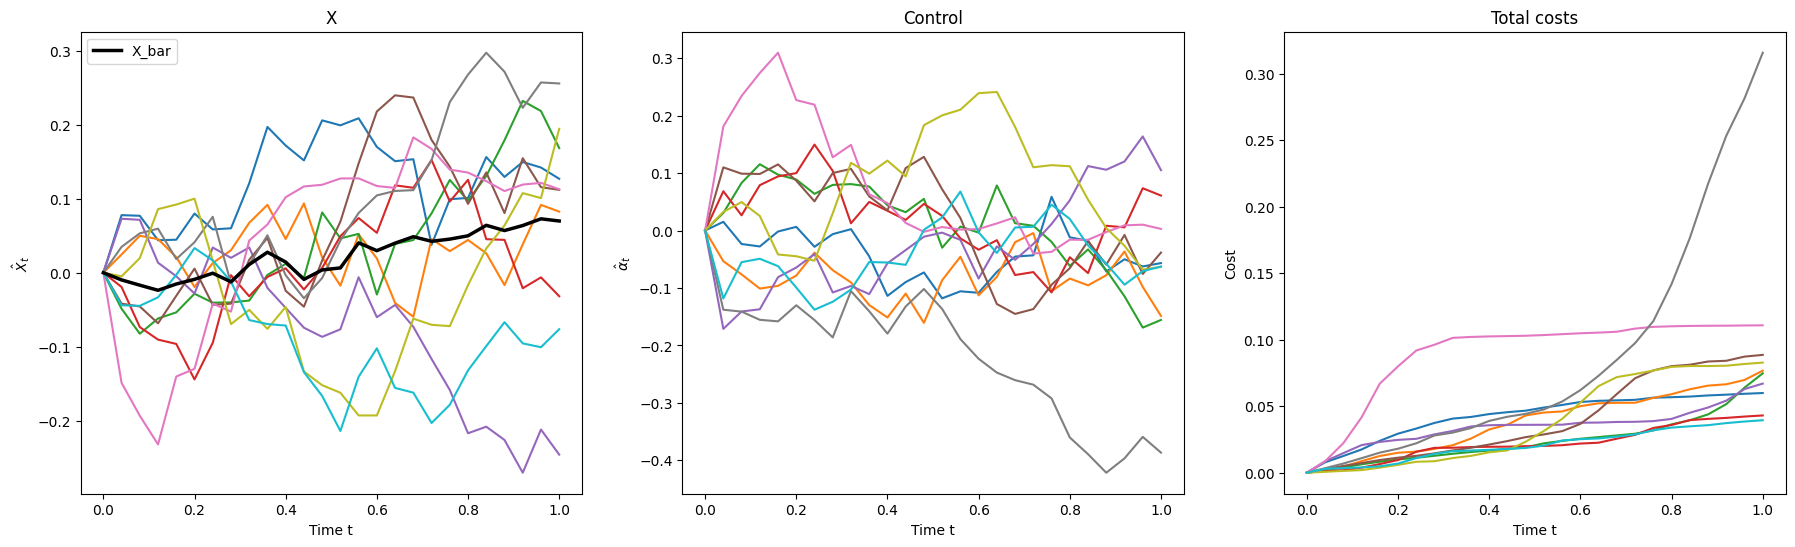

In [49]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(22, 6))
fig.set_facecolor('white')

t_axis = np.arange(start=0, stop=T+dt, step=dt)

ax1.set_title("X")
ax1.plot(t_axis, X_store)
ax1.plot(t_axis, X_bar, color='black', linewidth=2.5, label='X_bar')
ax1.set_xlabel("Time t")
ax1.set_ylabel("$\hat{X}_{t}$")
ax1.legend()

ax2.set_title("Control")
ax2.plot(np.arange(start=0, stop=T+dt, step=dt), alpha_store)
ax2.set_xlabel("Time t")
ax2.set_ylabel(r"$\hat{\alpha}_{t}$")

ax3.set_title("Total costs")
ax3.plot(np.arange(start=0, stop=T+dt, step=dt), total_cost)
ax3.set_xlabel("Time t")
ax3.set_ylabel("Cost")

plt.show()